In [1]:
import torch
from feature_extractor import load_feature_extractor

In [2]:
model = load_feature_extractor()

File exists already!


---

In [3]:
x0 = torch.zeros((3,256,256))
x1 = torch.ones((3,256,256))
x2 = 2*torch.ones((3,256,256))
x3 = 3*torch.ones((3,256,256))
x01 = torch.cat((x0, x1),0)
x23 = torch.cat((x2, x3),0)
y01 = model(x01.unsqueeze(0))
y23 = model(x23.unsqueeze(0))

In [13]:
y01.shape

torch.Size([1, 131072])

In [11]:
x01.flatten().shape

torch.Size([393216])

In [5]:
x = torch.stack([x01,x23])
x.shape

torch.Size([2, 6, 256, 256])

In [6]:
y = model(x)
y.shape

torch.Size([2, 131072])

In [9]:
torch.all(y[0] == y01)

tensor(True)

In [10]:
torch.all(y[1] == y23)

tensor(True)

---

In [6]:
x0 = torch.zeros((3,256,256))
x1 = torch.ones((3,256,256))
x01 = torch.cat((x0, x1),0)
y01 = model(x01.unsqueeze(0))

def tensor_mem(x):
    return x.element_size() * x.nelement() * 1e-9

In [10]:
sizet = tensor_mem(y01)

In [32]:
sizet

0.000524288

In [29]:
sizet * 9573

5.019009024000001

In [28]:
sizet * 16874

8.846835712

In [31]:
sizet * 7630

4.00031744

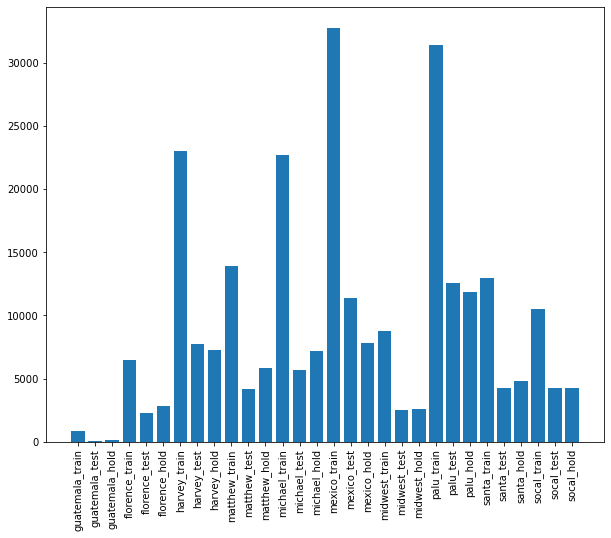

In [27]:
D = {
    'guatemala_train' : 1712 // 2,
    'guatemala_test' : 64 // 2,
    'guatemala_hold' : 206 // 2,
    'florence_train' : 12892 // 2,
    'florence_test' : 4536 // 2,
    'florence_hold' : 5668 // 2,
    'harvey_train' : 46028 // 2,
    'harvey_test' : 15430 // 2,
    'harvey_hold' : 14452 // 2,
    'matthew_train' : 27878 // 2,
    'matthew_test' : 8378 // 2,
    'matthew_hold' : 11672 // 2,
    'michael_train' : 45372 // 2,
    'michael_test' : 11314 // 2,
    'michael_hold' : 14316 // 2,
    'mexico_train' : 65542 // 2,
    'mexico_test' : 22822 // 2,
    'mexico_hold' : 15582 // 2,
    'midwest_train' : 17512 // 2,
    'midwest_test' : 5064 // 2,
    'midwest_hold' : 5216 // 2,
    'palu_train' : 62788 // 2,
    'palu_test' : 25120 // 2,
    'palu_hold' : 23670 // 2,
    'santa_train' : 25900 // 2,
    'santa_test' : 8452 // 2,
    'santa_hold' : 9558 // 2,
    'socal_train' : 20950 // 2,
    'socal_test' : 8544 // 2,
    'socal_hold' : 8444 // 2
}

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.bar(range(len(D)), list(D.values()), align='center');
plt.xticks(range(len(D)), list(D.keys()), rotation=90);

In [20]:
guatemala = D['guatemala_hold'] + D['guatemala_test'] + D['guatemala_train']
sizet * guatemala

0.5195694080000001

In [21]:
guatemala

991

In [23]:
socal = D['socal_train'] + D['socal_test'] + D['socal_hold']
sizet * socal

9.945219072

In [17]:
sizet * D['mexico_train']

34.363408384

---

In [14]:
df.iloc[0,0].replace('(','').replace(')','').split(',')

['465.94617850181066', ' 109.62942748980328']

---

In [2]:
import pandas as pd
from pathlib import Path
xbd_path = 'datasets/xbd'
subsets = ('/train_bldgs/', '/hold_bldgs/', '/test_bldgs/')

disaster_folders = os.listdir(xbd_path + subsets[0])
disaster_folders_tier3 = os.listdir(xbd_path + '/tier3_bldgs/')

for subset in subsets:
    subset_marker = subset[subset.find('/')+len('/'):subset.rfind('_')]
    for disaster in disaster_folders:
        print(list(Path(xbd_path + subset + disaster).glob('*.csv*'))[0])
        labels = pd.read_csv(list(Path(xbd_path + subset + disaster).glob('*.csv*'))[0])
        break
    break

datasets\xbd\train_bldgs\guatemala-volcano\guatemala-volcano_train_labels.csv


In [14]:
from math import sqrt
labels.columns = ['name', 'xcoords', 'ycoords', 'class']
norm = lambda row: sqrt(row[1]**2 + row[2]**2)
labels['norm'] = labels.apply(norm, axis=1)
labels.head()

,name,xcoords,ycoords,class,norm
0,guatemala-volcano_00000000_post_disaster_0.png,485.912146,215.775709,no-damage,531.666973
1,guatemala-volcano_00000000_post_disaster_1.png,825.060485,755.521020,no-damage,1118.721063
2,guatemala-volcano_00000000_post_disaster_2.png,1001.802266,840.883008,no-damage,1307.934254
3,guatemala-volcano_00000000_post_disaster_3.png,1015.641853,916.529460,no-damage,1368.047742
4,guatemala-volcano_00000000_post_disaster_4.png,995.523131,946.768692,no-damage,1373.840333


In [16]:
annotation.value_counts()

no-damage        731
un-classified    178
destroyed         33
minor-damage      26
major-damage      23
Name: class, dtype: int64

---

In [29]:
import torch

a = torch.tensor([[0.8, 0.1, 0, 0],[0.7,0.6,0.3,0.2],[0.8,0.7,0.9,0.6]])

idx = torch.where(a < 0.5, 1, 0)

idx

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 0]])

In [30]:
nz = torch.argmax(idx,dim=1)
nz

tensor([1, 2, 0])

In [32]:
torch.where(nz == 0, 4, nz)

tensor([1, 2, 4])

---